In [2]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

!pip3 install -q torch torchvision
!pip3 install -q Pillow

In [30]:
import pandas as pd
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms
import torchvision.datasets as dset
from PIL import Image
from skimage import io, transform
import torch
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0") # Let's make sure GPU is available!

In [31]:
train_folder = "../5_transfer_learning/hotdog-not-hotdog-dataset/train/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

test_folder = "../5_transfer_learning/hotdog-not-hotdog-dataset/test/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 2
Number of files in the test folder 2


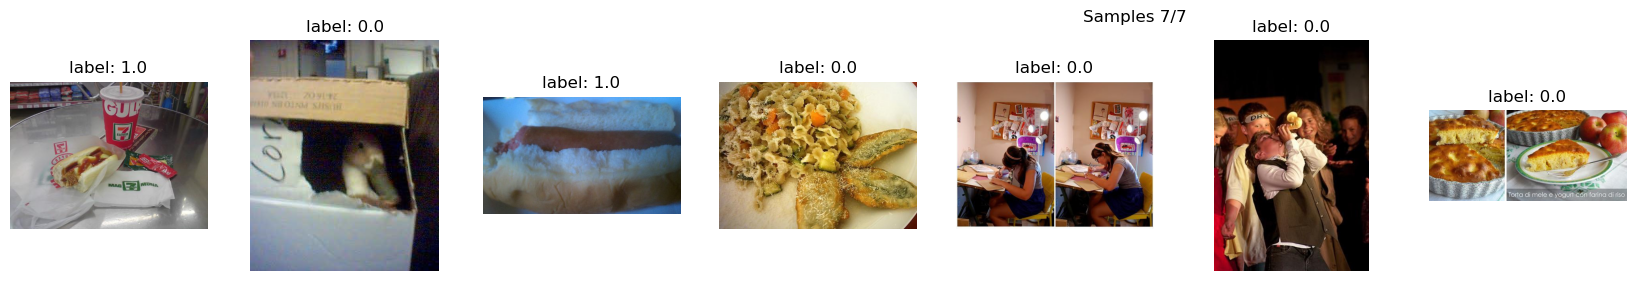

In [32]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder

        data_is_hotdog = pd.DataFrame(os.listdir(folder + "hot_dog/"), columns=["img"], index=None)
        data_not_hotdog = pd.DataFrame(os.listdir(folder + "not_hot_dog/"), columns=["img"], index=None)
        data_is_hotdog["target"] = 1.0
        data_not_hotdog["target"] = 0.0
        data_is_hotdog["path"] = "hot_dog"
        data_not_hotdog["path"] = "not_hot_dog"
        self.data = pd.concat([data_is_hotdog, data_not_hotdog], axis=0)
        self.data = self.data.sample(frac=1).reset_index(drop=True)
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        img_id = index
        if torch.is_tensor(index):
            idx = idx.tolist()

        image_path = os.path.join(self.folder +  self.data["path"][index], self.data["img"][index])
        img = Image.open(image_path)

        y = self.data["target"].iloc[index]

        if self.transform:
            img = self.transform(img)
        
        return img, y, img_id

def visualize_samples(dataset, indices, title=None, reshape=False, count=10):
    plt.figure(figsize=(count * 3, 3))
    display_indices = indices[:count]
    if title:
        plt.suptitle(f"{title} {len(display_indices)}/{len(indices)}")

    for i, index in enumerate(display_indices):
        x, y, _ = dataset[index]
        if reshape:
            x = x.T
        plt.subplot(1, count, i + 1)
        plt.title("label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis("off")

orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

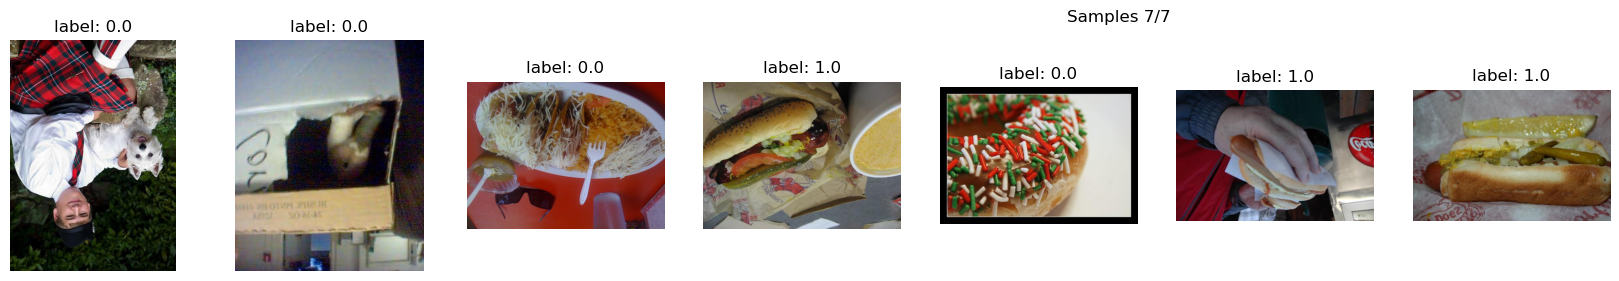

In [33]:
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples")

In [34]:
train_dataset = HotdogOrNotDataset(train_folder,
                                  transform=transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
                                  ]))
test_dataset = HotdogOrNotDataset(test_folder,
                                  transform=transforms.Compose([
                                      transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
                                  ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


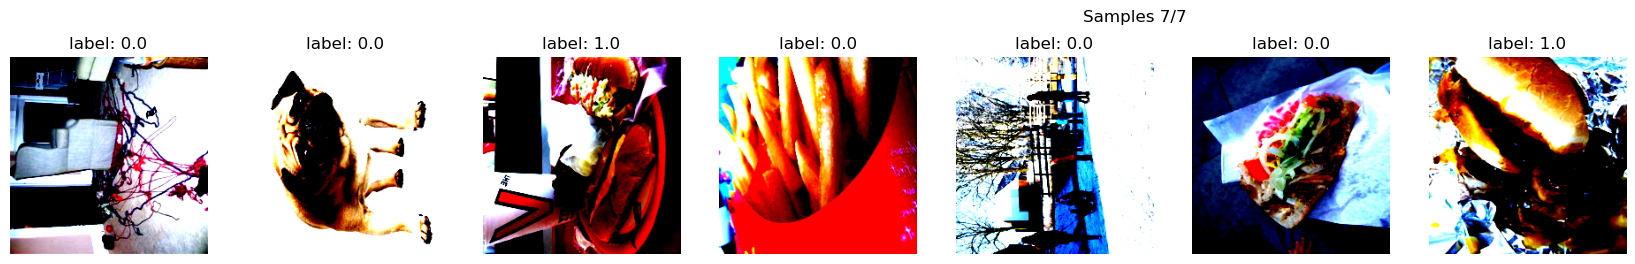

In [35]:
visualize_samples(train_dataset, indices, "Samples", True)

In [36]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size)

In [62]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        total_samples = 0
        correct_samples = 0
        loss_accum = 0
        
        model.train()
        for i, (x, y, _) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            # x_gpu = x
            # y_gpu = y
            prediction = model(x_gpu)

            loss_value = loss(torch.reshape(prediction, y_gpu.shape), y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i
        scheduler.step()
        train_accuracy = float(correct_samples / total_samples)
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print(epoch + 1, "Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    return loss_history, train_history, val_history 

def compute_accuracy(model, loader):
    correct_samples = 0
    total_samples = 0
    model.eval()
    
    for (x, y, _) in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)

        cat_prediction = model(x_gpu)
        prediction = torch.argmax(cat_prediction, dim=1)

        correct_samples += torch.sum(y_gpu == prediction)
        total_samples += y_gpu.shape[0]

    return correct_samples / total_samples    

In [46]:
def load_imagenet_classes():
    classes_json = urllib.request.urlopen("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").read()
    classes = json.loads(classes_json)
    return { int(k): v[-1] for k, v in classes.items()}

model = models.resnet18(weights='IMAGENET1K_V1')

In [25]:
imagenet_dict = load_imagenet_classes()

In [26]:
def visualize_x(loader, counter, model):
    for batch in loader:
        inputs, targets, _ = batch
        y = torch.argmax(model(inputs), axis=1)
        for i in range(counter):
            img = inputs[i]
            image  = img.cpu().numpy()
            title = imagenet_dict[int(y[i])]
            
            # transpose image to fit plt input
            image = image.T
            # normalise image
            data_min = np.min(image, axis=(1,2), keepdims=True)
            data_max = np.max(image, axis=(1,2), keepdims=True)
            scaled_data = (image - data_min) / (data_max - data_min)
            # show image
            plt.title(title)
            plt.imshow(scaled_data)
            plt.show() 
        break

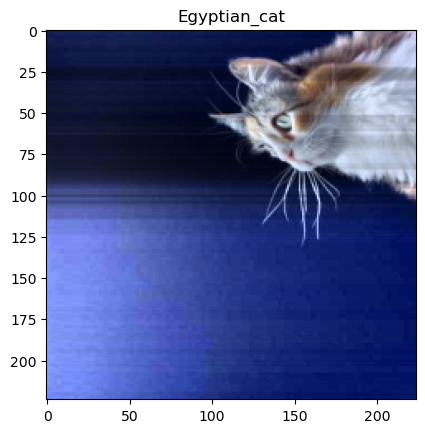

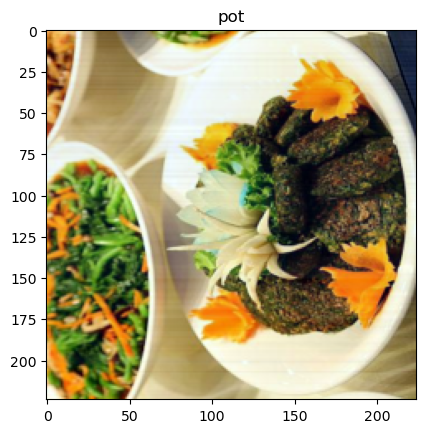

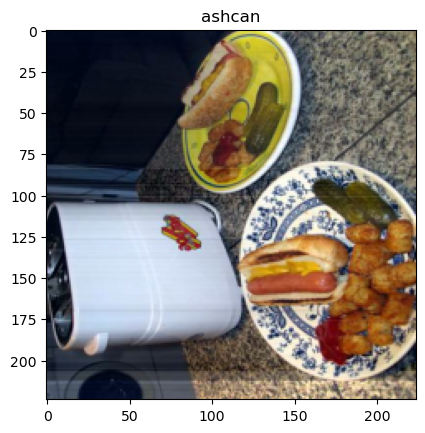

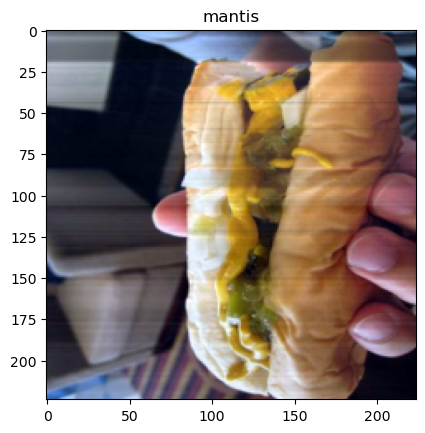

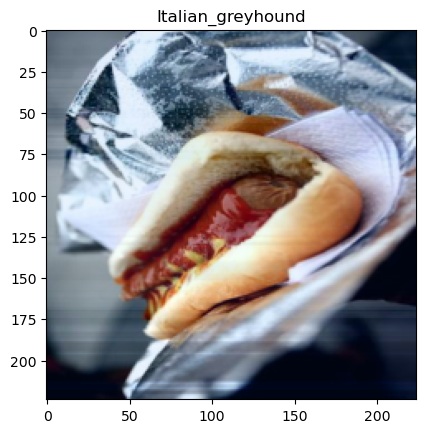

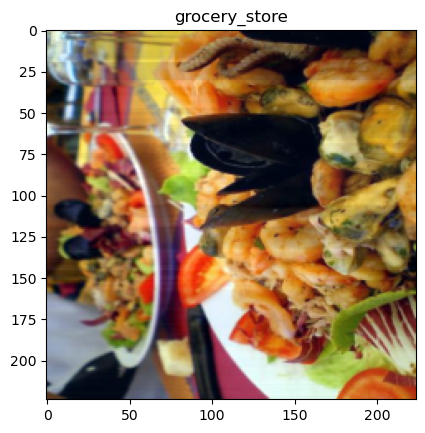

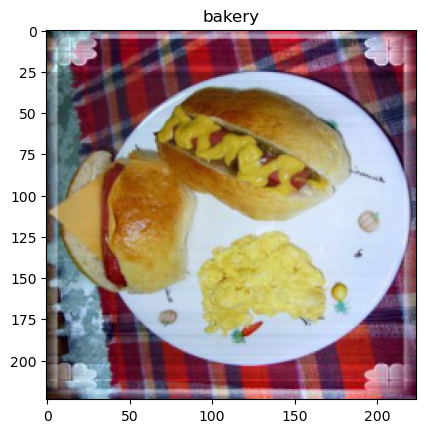

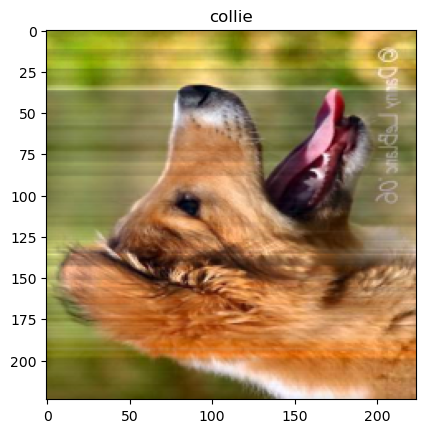

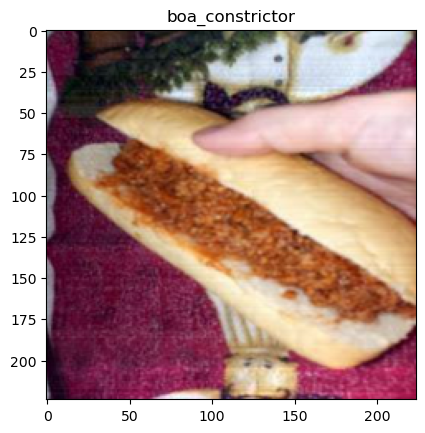

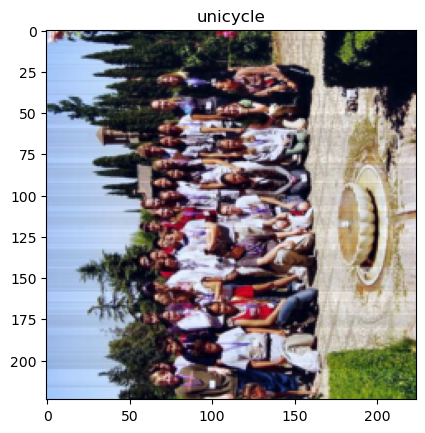

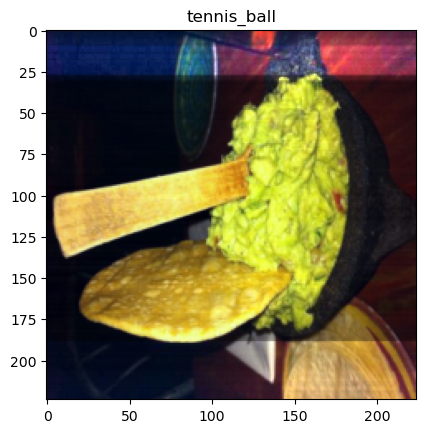

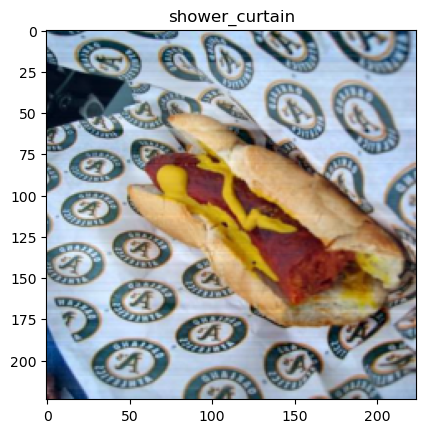

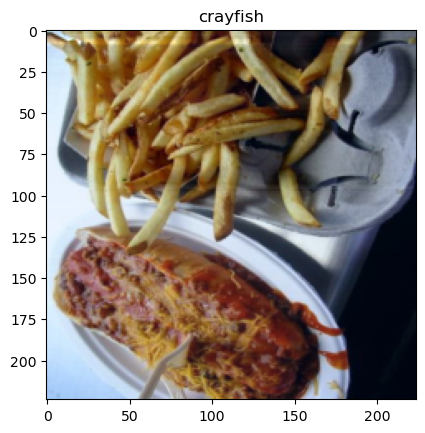

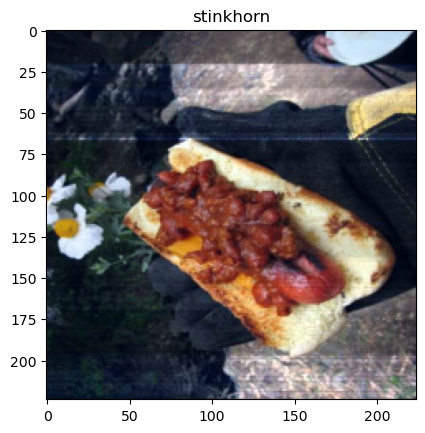

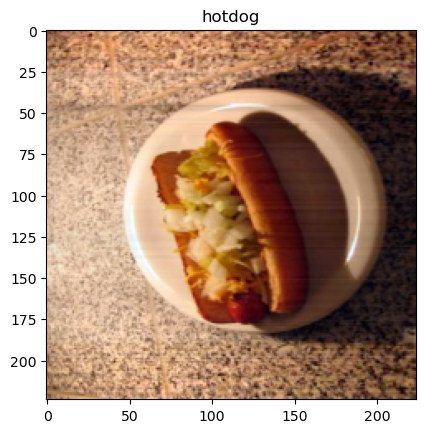

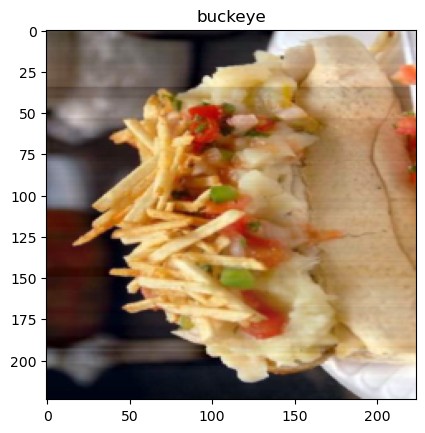

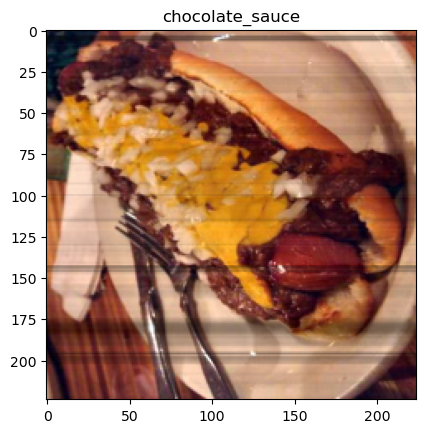

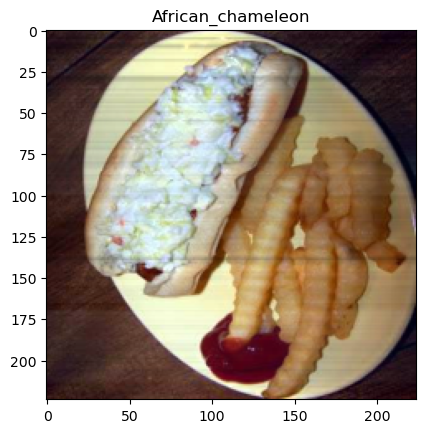

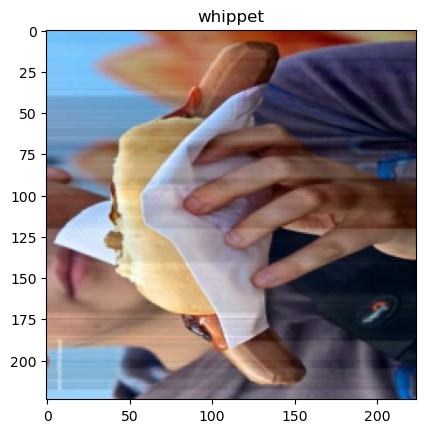

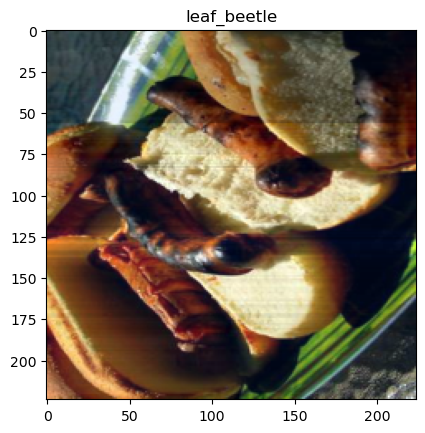

In [27]:
visualize_x(train_loader, 20, model)

### Перенос обучения (transfer learning) - тренировать только последний слой

In [63]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
for param in model_ft.parameters(): #морозим градиенты
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 1)

model_ft.type(torch.cuda.FloatTensor)
model_ft = model_ft.to(device)

# model_ft.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
# loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

optimizer_ft = optim.Adam(model_ft.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [64]:
loss_history, train_history, val_history = train_model(model_ft, train_loader, val_loader, loss, 
                                                       optimizer=optimizer_ft, scheduler=exp_lr_scheduler, 
                                                       num_epochs=2)

1 Average loss: 136.483924, Train accuracy: 0.463216, Val accuracy: 0.469150
2 Average loss: 133.742365, Train accuracy: 0.463216, Val accuracy: 0.469150


### Перенос обучения (transfer learning) - тренировать всю модель

In [ ]:
def train_model_transfer_learning(model, train_loader, val_loader, loss, optimizer,
                                  scheduler, num_epochs, optimizers):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        total_samples = 0
        correct_samples = 0
        loss_accum = 0
        
        model.train()
        for i, (x, y, _) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)

            loss_value = loss(torch.reshape(prediction, y_gpu.shape), y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i
        scheduler.step()
        train_accuracy = float(correct_samples / total_samples)
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print(epoch + 1, "Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    return loss_history, train_history, val_history 

In [73]:
model = models.resnet18(weights="IMAGENET1K_V1")

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

model.type(torch.cuda.FloatTensor)
model = model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': model.parameters(), 'lr': 1e-3}
    ], lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

ValueError: some parameters appear in more than one parameter group

In [82]:
len(model.modules())

TypeError: object of type 'generator' has no len()